In [3]:
%load_ext autoreload
%autoreload 2
import importlib
import numpy as np
from plots import *
from processing_funcs import *
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy import stats

In [70]:
def plot_spec(df, species=None, type='supp', scaled='no', num=0, filepath=None, save=False):
    if type=='supp':
        df = df[df['sr']==0]
    else:
        df = df[df['sr']!=0]
        
    if filepath is None and species is not None:
        row = df[(df['species'] == species)].iloc[num]
    elif filepath is not None:
        row = df.loc[df['filepath'] == filepath].iloc[0]
    elif filepath is None and species is None:
        row = df.iloc[num]
        
    if row['freqs'] is None or len(row['freqs']) == 0:
        freqs = rfftfreq(32768, 1 / row['sr'])
    else:
        freqs = row['freqs']
        
    if scaled and 'scaled spectrum' in df:
        spectrum = row['scaled spectrum']
    else:
        spectrum = row['spectrum']

    print(spectrum[500])
    path = Path(row['filepath'])
    species = row['species']
    plt.figure(num)
    plt.plot(freqs/1000, spectrum)
    plt.xlabel("Frequency (kHz)")
    plt.ylabel("dB SPL")
    plt.ylim(0, 10)
    title = f"{species} SOAE Spectrum ({path.name})"
    plt.title(title)
    if save:
        plt.savefig(path.name + ".png")
    plt.show()

-6.873615954798379


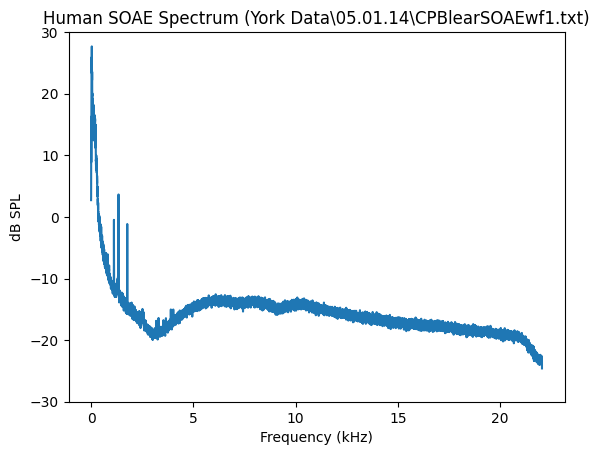

-9.38744


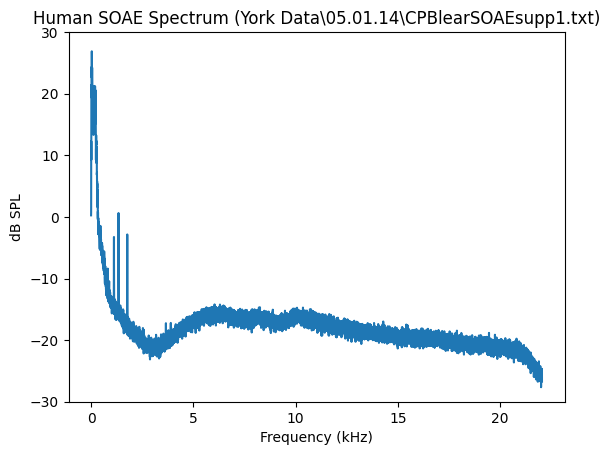

-12.894215868078003


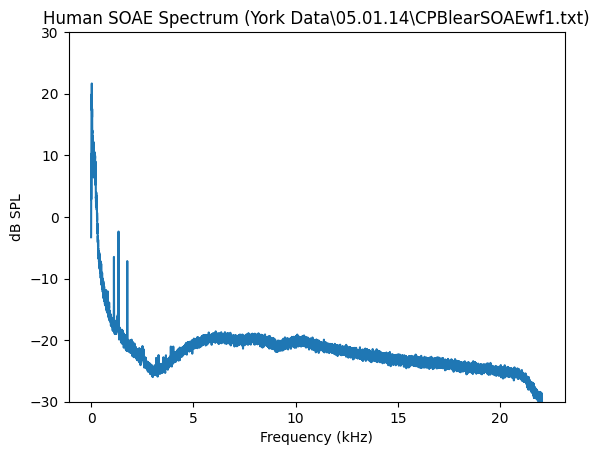

In [79]:
# Load processed dataframe
dfp = pd.read_parquet("norm_processed_df.parquet")
plot_spec(dfp, type='wf', scaled='no', species='Human', num=8)
# plot_spec(dfp, type='supp', scaled='no', species='Human', num=1)
plot_spec(dfp1, type='supp', scaled='no', filepath=r'York Data\05.01.14\CPBlearSOAEsupp1.txt',species='Human', num=0)
dfp1 = pd.read_parquet("1_norm_processed_df.parquet")
plot_spec(dfp1, type='wf', scaled='no', species='Human', num=8)

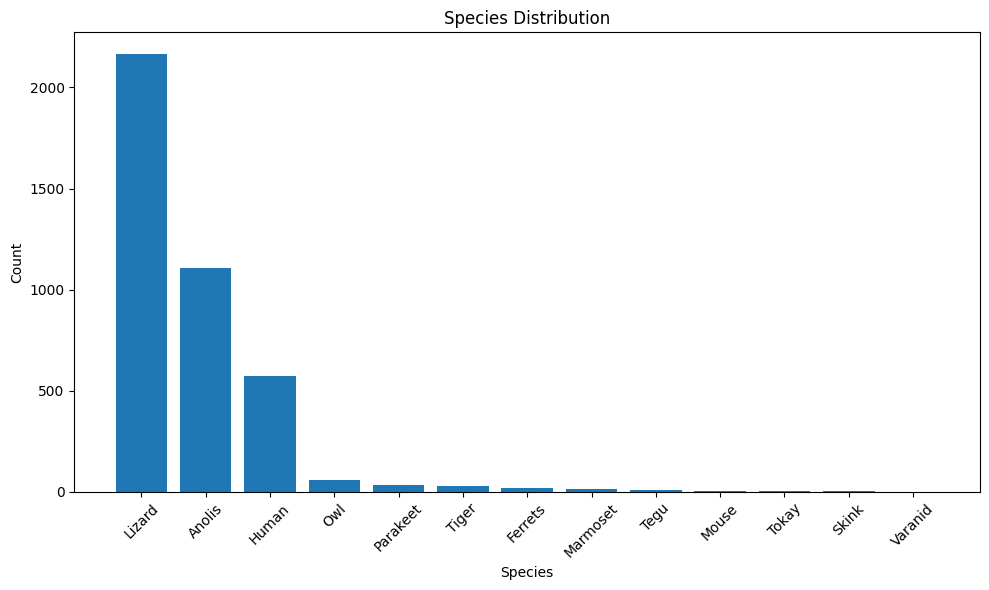

In [4]:
# Get number of each species and plot in a bar chart
species_counts = df[df['species']!=""]['species'].value_counts()

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(species_counts.index, species_counts.values)

# Add labels and title
plt.xlabel('Species')
plt.ylabel('Count')
plt.title('Species Distribution')
plt.xticks(rotation=45)  # Rotate labels for better readability if needed
plt.tight_layout()  # Adjust layout to prevent label cutoff
# plt.savefig('species_distribution.png', dpi=300, bbox_inches='tight')  # Adjust dpi and bounding box
plt.show()



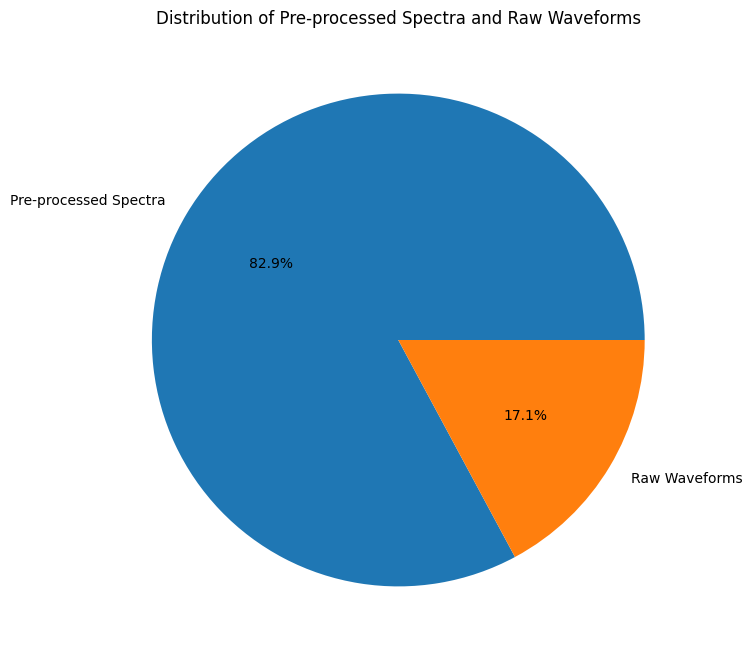

In [5]:
# Get how many are pre-processed
num_preprocessed = (df['sr'] == 0).sum()
num_wf = len(df) - num_preprocessed

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie([num_preprocessed, num_wf], labels=['Pre-processed Spectra', 'Raw Waveforms'], autopct='%1.1f%%')
plt.title('Distribution of Pre-processed Spectra and Raw Waveforms')
# plt.savefig('pp vs wf.png', dpi=300, bbox_inches='tight')  # Adjust dpi and bounding box
plt.show()

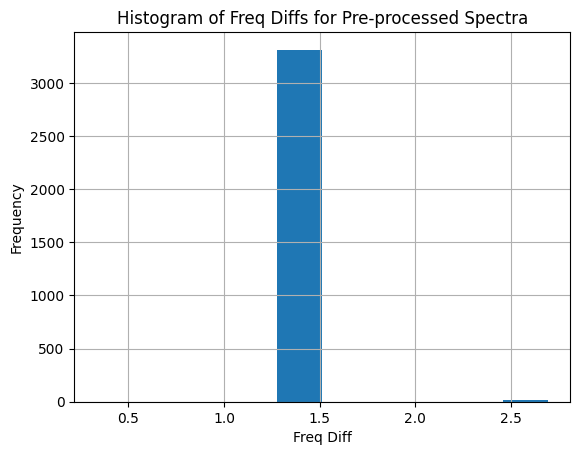

In [6]:
# Out of the preprocessed ones, get a histogram of the spacing between frequency bins
freq_diffs = df[df['sr'] == 0]['freqs'].apply(lambda x: x[100] - x[99])
freq_diffs.hist()
plt.title('Histogram of Freq Diffs for Pre-processed Spectra')
plt.xlabel('Freq Diff')
plt.ylabel('Frequency')
plt.show()

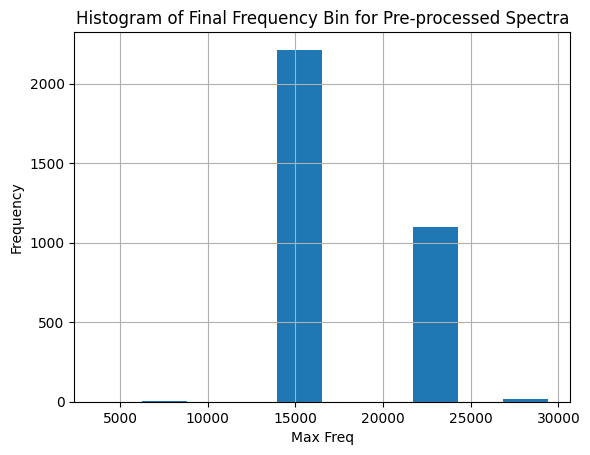

In [7]:
# Out of the preprocessed ones, get a histogram of the maximum frequency bin value
max_freqs = df[df['sr'] == 0]['freqs'].apply(lambda x: x[-1])
max_freqs.hist()
plt.title('Histogram of Final Frequency Bin for Pre-processed Spectra')
plt.xlabel('Max Freq')
plt.ylabel('Frequency')
plt.show()

/tmp/ipykernel_1162/632959221.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_supp['max_freq_category'] = max_freqs.apply(lambda x: '< 20000' if x < 20000 else '> 20000')


<Figure size 1200x600 with 0 Axes>

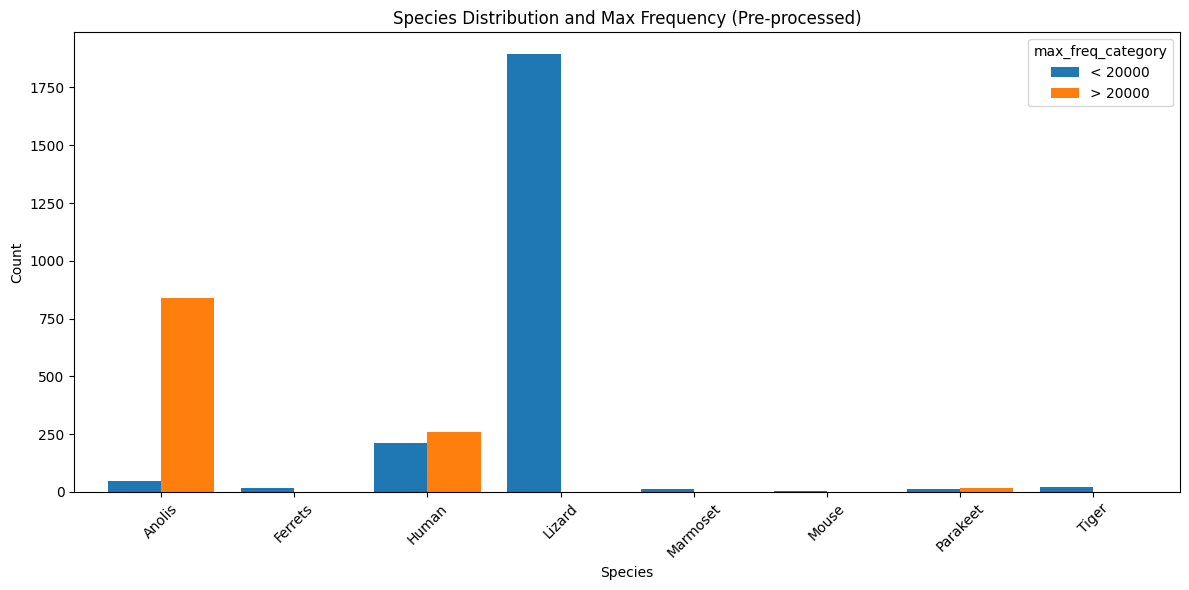

In [8]:
# Calculate max frequencies
df_supp = df[df['sr'] == 0]
max_freqs = df_supp['freqs'].apply(lambda x: x[-1])

# Add a new column to classify max frequencies into categories
df_supp['max_freq_category'] = max_freqs.apply(lambda x: '< 20000' if x < 20000 else '> 20000')

# Filter data for species with non-empty values
species_data = df_supp[df_supp['species'] != ""]

# Group data by species and max_freq_category, and count occurrences
grouped = species_data.groupby(['species', 'max_freq_category']).size().unstack(fill_value=0)

# Plot the double bar graph
plt.figure(figsize=(12, 6))
grouped.plot(kind='bar', width=0.8, figsize=(12, 6))

# Add labels and title
plt.xlabel('Species')
plt.ylabel('Count')
plt.title('Species Distribution and Max Frequency (Pre-processed)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Save and show the plot
# plt.savefig('species_max_freq_double_bar.png', dpi=300, bbox_inches='tight')
plt.show()


In [17]:

min_freq_length = df['freqs'].apply(len).min()
rows_with_min_freq = df['freqs'].apply(len).eq(min_freq_length).sum()
print(f"{rows_with_min_freq}/ {len(df)}")


2236/ 4024


In [39]:
# Throw out the samples that don't have the right frequency axis bin width (there's just a few)
target_value = 1.34583
precision = 5  # Round to 5 decimal places
wf_sr = 44100
wf_win = 32768

# Function to compute the difference and round it
def diff_is_target(row):
    # if it's a waveform, skipp
    if row['sr'] != 0:
        freqs = rfftfreq(wf_win, 1/wf_sr)
    # Otherwise, Get the array from the 'freqs' column
    else:
        freqs = np.array(row['freqs'])
    
    diff = freqs[1] - freqs[0]
    return round(diff, precision) == round(target_value, precision)

# Filter the dataframe
print(f"{len(df[df.apply(diff_is_target, axis=1)])}/ {len(df)}")

4002/ 4024


1.2999999999992724


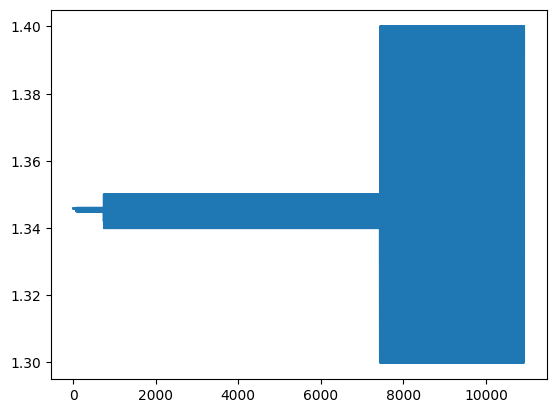

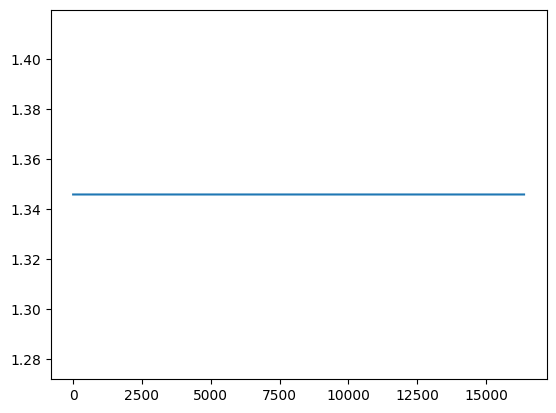

In [37]:

row = df.iloc[1020]
print(np.diff(row['freqs'])[9998])
# print(rfftfreq(32768, 1/44100)[10000])
plt.plot(np.diff(row['freqs']))
plt.show()
plt.plot(np.diff(rfftfreq(32768, 1/44100)))
plt.show()

